# ResNet20 on CIFAR-10 Dataset

---



In this lab, we will gain some practical experience using ResNet, a Deep Convolutional Neural Network (CNN) approach to object classification. Convolutional Neural Networks build up layers of convolutions, transforming an input image and distilling it down until they start recognizing composite features, with deeper layers of convolutions recognizing increasingly complex patterns.

ResNet was invented by Researchers at Microsoft Research Asia (Kaiming He, Xiangyu Zhang, Shaoqing Ren and Jian Sun), and it won first place in both ILSVRC and MS COCO competitions in 2015.

A great visual presentation from Kaiming He describing ResNet is available at:

http://image-net.org/challenges/talks/ilsvrc2015_deep_residual_learning_kaiminghe.pdf.

Whereas AlexNet (ILSVRC 2012 winner) had 8 layers, VGG (ILSRVC 2014) had 19 layers, and GoogleNet (ILSRVC 2014) had 22 layers, ResNet demonstrated a trainable network with a whopping 152 layers! This was quite a technical achievement at the time. ResNet managed this by resolving a phenomenon that had to this point been observed across many different datasets - namely, that deeper networks experienced higher training and test error than their shallower counterparts.

By contrast, deep ResNets can be easily trained, and in fact have lower training error and lower test error than comparable, shallower, networks. Furthermore, ResNets can learn better features which are more transferrable to networks used for other tasks. These better features lead to improved performance on object detection and segmentation tasks when using ResNet as the base classifier.

ResNets achieve this through the use of a technique called Residual Deep Learning. This is a technique that involves passing through the main signal of the input data, so that the network ultimately "learns" on just the residual portions that differ between layers. This has proven, in practice, to allow the training of much deeper networks by avoiding issues that plague gradient descent on larger networks. These cells bypass convolution layers and then come back in later before rectified linear unit (ReLU).

For this task, we have chosen ResNet20 as our trained model architecture. The code in this lab is based on https://keras.io/examples/cifar10_resnet/, and in particular the ResNet20 v1 model

We will use the Keras API for TensorFlow 2 in this example, along with NumPy, the Python library for multi-dimensional numerical computing.

Let's now import TensorFlow 2 and NumPy into our Python runtime.

In [0]:
from __future__ import print_function

#%tensorflow_version 2.x
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10

import numpy as np

To ensure these labs run as fast as possible, from the menu above select **Edit > Notebook settings** or **Runtime > Change runtime type** and select GPU as the Hardware accelerator option.

Let's test that we are running using the GPU. 

In [0]:
tf.test.gpu_device_name()

'/device:GPU:0'

If this outputs '', then we are running on CPU only. If it outputs something like '/device:GPU:0' then we are running on GPU. If you see something like ...

    Failed to assign a backend
    No backend with GPU available. WOuld you like to use a runtime with no accelerator?

This suggests that many other users have all the GPU resources on colab occupied at the moment, so perhaps try later or try using with the TPU instead.

# Preparing our Dataset

In this tutorial, we will be using the CIFAR-10 dataset (http://www.cs.toronto.edu/~kriz/cifar.html). 
CIFAR-10 is a popular dataset for image classification, collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton.

The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. 
There are 50,000 training images and 10,000 test images. The 10 classes are: 
    
 * airplane, 
 * automobile, 
 * bird, 
 * cat, 
 * deer,
 * dog,
 * frog,
 * horse,
 * ship, and 
 * truck.

The Keras interface to TensorFlow 2.x has specific helper functions to make our lives easy when downloading and using the CIFAR-10 dataset.

In [0]:
# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_test_orig = x_test
y_test_orig = y_test

# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train, x_test = x_train / 255.0, x_test / 255.0

# Subtracting the pixel mean improves accuracy
x_train_mean = np.mean(x_train, axis=0)
x_train -= x_train_mean
x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


We need to setup a few parameters we'll use later. We need to define the size of our mini-batch, the number of epochs we plan to train for, and the number of classes we are training for - in CIFAR-10, there are 10 separate labelled classes of object.

We'll set the depth of our network to 20, indicating we are building a ResNet20 classifier (the smallest model in the ResNet family).

Finally, we'll convert our labels from numeric class vectors to binary class matrices. Thsi is to ensure that training runs successfully. This will convert a class label of '3', for example, indicating 'cat', to `[ 0, 0, 0, 1, 0, 0, 0, 0, 0, 0 ]`.

In [0]:
# Training parameters
batch_size = 32  # orig paper trained all networks with batch_size=128
epochs = 200
num_classes = 10

depth = 20 

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# The ResNet Block Layer

## Basic Building Blocks of CNN

*Convolutional Neural Networks* (also known as *CNNs*, or *ConvNets*) typically stack convolutional layers, rectified linear unit (ReLU) activation layers, pooling layers, and finally fully connected layers. 

ResNet changes this slightly, and introduces a new trend towards smaller filters and deeper architectures, with fewer pooling and fully connected layers.

We need to create some basic building blocks for the ResNet model. Let's take a look at the Resnet *residual block*, which we will use to create our the full ResNet20 network architecture.

![The Residual Block](https://github.com/EmdaloTechnologies/CE6003/blob/master/images/lab4/residual_block_color.png?raw=1 "The Residual Block")

As you can see, the residual block consists of a stacking of convolutional, batch normalization, and rectified linear (ReLU) activation layers. This residual block is our basic building block for ResNet.  We explained how it works in our video lectures for this module, and will recap on this shortly.  

So we now have a function to create a convolutional weights layer with back normalization at the end, and one which also has a rectified linear unit (ReLU) after it.  We're next going to combine both of these into the fundamental building block of ResNet, the *Residual Block*.

## The Residual Block and Skip Connections

The following function will create the residual block, and a version of the residual block that also adds in input passed through a single convolutional layer and batch norm.

![resnet_basic_blocks](https://github.com/EmdaloTechnologies/CE6003/blob/master/images/lab4/resnet_basic_blocks.png?raw=1 "ResNet basic building blocks")

We can see the skip connection implemented above with the addition of x plus either the input layer or y, i.e.: 

$ x = x + y$


Now we need to create some code to stack layers together, increasing the number of filters and decreasing the spatial size of the data as it progresses through the network.


## Exercise

Here, we need to create a `resnet_layer` function with the following function prototype, to complete this lab:

    def resnet_layer(inputs, num_filters=16, kernel_size=3,
                     strides=1, activation='relu', batch_normalization=True,
                     conv_first=True):


The function needs to create a stack of Keras layers. specifically Conv2D, BatchNormalization, and Activation:

 * if `conv_first` is True, then the first layer needs to be a Conv2D layer using the specified number of filters, kernel size, stride;
     * You can use `same` for padding, `he_normal` for the kernel initializer, and `l2(1e-4)` for the kernel regularizer.
 * if `batch_normalization`is True, then add a BatchNormalization layer to the Conv2D layer
 * if activation is not `None`, then add an Activation layer to the BatchNormalizationLayer

Then return the stack.

You can find out more about the Keras Layers API at https://keras.io/layers/about-keras-layers/ :

 * Convolutional Layers are described at https://keras.io/layers/convolutional/
 * Normalization layers are described at https://keras.io/layers/normalization/
 * Activation layers are described at https://keras.io/layers/advanced-activations/
 

In [0]:
# Exercise: Your Code Here

def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):#The function needs to create a stack of Keras layers. specifically Conv2D, BatchNormalization, and Activation
  
  # Put your code here
  #inspartaion from the example at https://keras.io/examples/cifar10_resnet/

    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters, kernel_size=kernel_size, strides=strides, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4)) 
    #if conv_first is True, then the first layer needs to be a Conv2D layer using the specified number of filters, kernel size, stride, 
    #you can use same for padding, he_normal for the kernel initializer, and l2(1e-4) for the kernel regularizer.
    
    x = inputs
    
    if conv_first:
        x = conv(x)
        if activation is not None:
            x = Activation(activation)(x)
        if batch_normalization:
            x = BatchNormalization()(x)

    else:
        if activation is not None:
            x = Activation(activation)(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        x = conv(x)
    return x


# ResNet20 Network Architecture

With these functions, we now have enough to plumb together the architecture of ResNet20.  We are using the network architecture of ResNet defined in the [ResNet paper](http://arxiv.org/abs/1512.03385), also known as ResNet v1.
 
The network ends with a global average pooling, a 10-way fully-connected layer, and softmax. [Batch normalization](https://arxiv.org/abs/1502.03167) is applied everywhere except the last fully-connected layer.

For now, let's look at how we stack our building blocks above blocks together to form the ResNet20 model.  At the beginning, we have a single convolutional weights layer, followed by a batch normalization layer and a rectified linear unit.  Then we have our residual units, and we end with an average pooling layer and a fully-connected (also called a *dense*) layer which gives us our class predictions.

In the deeper ResNet Models, bottleneck blocks are introduced for computational considerations - i.e., they serve to reduce the dimensionality of the network, which will help prevent overfitting and improve inference and training time. In all ResNet variants, dimensionality is reduced at the end by the global average pooling layer. This layer further helps minimize the chances of overfitting by reducing the number of total parameters within the model (i.e., reducing the spatial dimensions of 3D tensors). See https://arxiv.org/pdf/1312.4400.pdf (especially section 3.2) for more details on global average pooling. ResNet doesn't require the use of dropout because it uses global average pooling instead to reduce the dimensionality before the dense fully-connected layer.

ResNet20 doesn't use bottlenecks, so we won't discuss this further in this lab.

Here is the full ResNet20 network architecture:

![ResNet20 model](https://github.com/EmdaloTechnologies/CE6003/blob/master/images/lab4/resnet20_model_color.png?raw=1 "ResNet20 Network Architecture")



In [0]:
def resnet_v1(input_shape, depth, num_classes=10):
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)

    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x, num_filters=num_filters, strides=strides)
            y = resnet_layer(inputs=y, num_filters=num_filters, activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x, num_filters=num_filters,
                                 kernel_size=1, strides=strides,
                                 activation=None, batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    model = Model(inputs=inputs, outputs=outputs)
    return model

Now that we have defined our model creation function, we'll instantiate a model, and compile it.  Remember that compiling, in Keras, configures the model for training - it defines the loss function, the optimizer and metrics. 

Compiling does not affect or modify the weights, and you can compile a model as often as you want without affecting pretrained weights.

In [0]:
model = resnet_v1(input_shape=input_shape, depth=depth)
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()

# Uncomment the following line to plot the model visually - warning, even for ResNet20, it is quite large!
# keras.utils.plot_model(model, dpi=48)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          activation[0][0]                 
______________________________________________________________________________________________


# Training

Now that we have our model created, it is time to perform training to fit our model weights to our training data. Conceptually, the flow is as follows - we evaluate the error for the class prediction of a test image with a known label using our current set of weights, and then we use back-propagation to adjust our weights slightly to reduce this error. We do this for all the examples in our training set. This is one *epoch*. Then we repeat until either a fixed numer of epochs or, more likely, until our error has reduced to a suitable small number.

In practice, we are splitting our test data in smaller chunks called mini-batches. When all of the training data has been processed once across a number of mini-batches, this is will be an *epoch*.

Using mini-batches has a number of advantages over single batch for training. Firstly, it uses less peak memory and therefore allows much larger training sets than might otherwise be feasible.  Secondly, it acts as a source of noise.  This small level of noise ensures that you escape being trapped in any local minima. Using minibatching does require that error information is accumulated across the entire epoch before doing backpropagation.

![Training Workflow](https://github.com/EmdaloTechnologies/CE6003/blob/master/images/lab4/cnn_training.gif?raw=1 "Training Workflow")

We will attempt to train for 20 epochs. This will take about 15-20 minutes on Colab. If you want, you can reduce the `epochs = 20` line in the code to a smaller number, to train quicker, perhaps 5. Or increase it to 50, to see the difference training for longer makes to the training curves.


In [0]:
datagen = keras.preprocessing.image.ImageDataGenerator(rotation_range=20, zoom_range=0.1, width_shift_range=0.15, height_shift_range=0.15, shear_range=0.1, horizontal_flip=True, fill_mode="nearest")
datagen.fit(x_train)
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),validation_data=(x_test, y_test),epochs=epochs, verbose=1)
#history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), shuffle=True)

Epoch 1/200
1563/1563 [==============================] - 269s 172ms/step - loss: 1.7047 - accuracy: 0.4395 - val_loss: 1.9674 - val_accuracy: 0.4085
Epoch 2/200
1563/1563 [==============================] - 266s 170ms/step - loss: 1.3493 - accuracy: 0.5720 - val_loss: 1.4847 - val_accuracy: 0.5704
Epoch 3/200
1563/1563 [==============================] - 266s 170ms/step - loss: 1.1832 - accuracy: 0.6382 - val_loss: 1.1566 - val_accuracy: 0.6561
Epoch 4/200
1563/1563 [==============================] - 266s 170ms/step - loss: 1.0831 - accuracy: 0.6794 - val_loss: 1.3876 - val_accuracy: 0.6201
Epoch 5/200
1563/1563 [==============================] - 266s 170ms/step - loss: 1.0134 - accuracy: 0.7053 - val_loss: 1.0334 - val_accuracy: 0.7099
Epoch 6/200
1563/1563 [==============================] - 266s 170ms/step - loss: 0.9587 - accuracy: 0.7284 - val_loss: 1.0139 - val_accuracy: 0.7209
Epoch 7/200
1563/1563 [==============================] - 266s 170ms/step - loss: 0.9224 - accuracy: 0.7409

Now that we have finished training, let's again take a look at our training history and plot our training curves.  

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


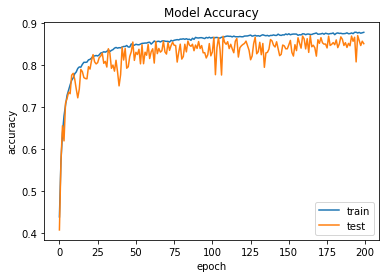

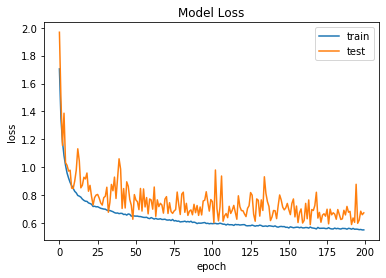

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [0]:
print(history.history.keys())

import matplotlib.pyplot as plt
# this next line is just Jupyter Notebook magic to plot inline in the webpage...
%matplotlib inline 

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Next, we'll take a look at our predictions. In this case, we're going to cheat and reuse our x_test, pretending it is unseen data...

In [0]:
predictions = model.predict(x_test)

We're going to define a helper function, `find_index_of_max_value_in_array`, to locate the index of the element in an array with the highest numerical value. We'll use thi later to find the most likely class based on our set of probability scores for a particular inference.

In [0]:
def find_index_of_max_value_in_array(input_array, input_index):
  score_index = np.where(input_array[input_index] == np.amax(input_array[input_index]))
  score_index = np.squeeze(score_index, axis=(0,1)).item()
  return score_index

The following code block is going to plot our predictions in a table - you don't need to worry about how it works exactly -- instead, focus on the table which shows the test images, the predicted label, the actual ground truth label in each case, and the full set of prediction scores.

,image_data,truth,prediction,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
0,,cat,cat,0.0000,0.0001,0.0001,0.9904,0.0000,0.0026,0.0062,0.0000,0.0000,0.0005
1,,ship,ship,0.0000,0.0080,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.9920,0.0000
2,,ship,ship,0.0007,0.2466,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.7459,0.0067
3,,airplane,truck,0.3796,0.1108,0.0014,0.0020,0.0000,0.0000,0.0001,0.0000,0.1083,0.3979
4,,frog,frog,0.0000,0.0000,0.0003,0.0000,0.0000,0.0000,0.9996,0.0000,0.0000,0.0000
5,,frog,frog,0.0000,0.0000,0.0001,0.0002,0.0003,0.0003,0.9990,0.0000,0.0000,0.0000
6,,automobile,automobile,0.0000,0.9953,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0047
7,,frog,frog,0.0001,0.0000,0.0078,0.0008,0.0008,0.0001,0.9899,0.0001,0.0000,0.0005
8,,cat,cat,0.0000,0.0000,0.0002,0.9394,0.0369,0.0099,0.0130,0.0001,0.0001,0.0004
9,,automobile,truck,0.0001,0.3856,0.0002,0.0000,0.0002,0.0000,0.0000,0.0000,0.0001,0.6138

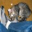
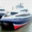
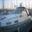
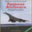
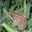
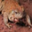
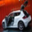
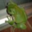
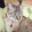
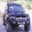
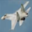
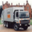
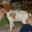
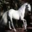
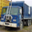
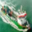
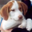
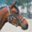
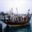
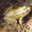
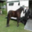
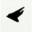
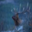
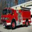
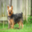
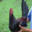
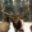
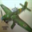
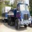
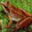

27 of 30 prediction were correct


In [16]:
#
# This code is to allow us to inline our images for display in a table...
#
from IPython.display import HTML, display
import urllib
import pandas
import PIL.Image
import io
import base64
import cv2

pandas.set_option('display.max_colwidth', -1)

labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# this function will take an index for a test set image, and convert it to base64 encoding
def encode_image_as_base64(xtest_index):
  temp  = io.BytesIO()
  image = PIL.Image.fromarray(x_test_orig[xtest_index], 'RGB')
  image.save(temp, format="png")
  return base64.b64encode(temp.getvalue()).decode()

# this function acts as a formatting, mapping a test set image number to that image, in base64 format
def map_image_data_to_inline_image(xtest_index):
  return '<img src="data:image/jpeg;base64,{}" width=64 height=64 alt=IMAGE />'.format(encode_image_as_base64(xtest_index))
  
#
# The following code will build and display our table of images, ground truth, prediction, and prediction probability scores
#

pred_count=0
num_images = 30
precision = "{:.4f}"
correct_count = 0

my_results = []

for prediction in predictions:
  true_label = y_test_orig[pred_count][0]
  predicted_label = find_index_of_max_value_in_array(predictions, pred_count);

  my_results.append({"image_data":   pred_count, 
                      "truth":       labels[true_label],
                      "prediction":  labels[predicted_label],
                      labels[0]:     precision.format(prediction[0]),
                      labels[1]:     precision.format(prediction[1]),
                      labels[2]:     precision.format(prediction[2]),
                      labels[3]:     precision.format(prediction[3]),
                      labels[4]:     precision.format(prediction[4]),
                      labels[5]:     precision.format(prediction[5]),
                      labels[6]:     precision.format(prediction[6]),
                      labels[7]:     precision.format(prediction[7]),
                      labels[8]:     precision.format(prediction[8]),
                      labels[9]:     precision.format(prediction[9]) })

  pred_count += 1;

  if predicted_label == true_label:
    correct_count += 1

  if pred_count >= num_images:
    break

  if pred_count % 100 == 0:
    print("Processed {0} samples ({1:.2%} correct)".format(pred_count, (float(correct_count) / pred_count)))

# Let's format our results table nicely for Jupyter Notebook
# we'll use a Pandas DataFrame, and re-order the columns slightly so that the image,
# ground truth label and best prediction are displayed first...
df = pandas.DataFrame(my_results)
cols = list(df.columns.values)
cols.pop(cols.index('image_data'))
cols.pop(cols.index('truth'))
cols.pop(cols.index('prediction'))
df = df[['image_data'] + ['truth']+ ['prediction'] + cols]


# and finally, render it as a nice HTML table below
display(HTML(df.to_html(escape=False, formatters=dict(image_data=map_image_data_to_inline_image))))
            
print ("{0} of {1} prediction were correct".format(correct_count, pred_count))


# Experiments

1. Consider changing `num_epochs` from 20 to 50, and repeating the lab. What happens to the training curves now?

**Note:** Google Colab notebooks have an idle timeout of 90 minutes and absolute timeout of 12 hours. This means, if user does not interact with a running Google Colab notebook for more than 90 minutes, its instance is automatically terminated. Also, maximum lifetime of a Colab instance is 12 hours.  As each epoch of this lab on a GPU takes between 30 seconds and 1 minute to train (presumably depending on the load on Colab), if you want to increase the number of epochs to be 90 or more, then remember to interact with the notebook somehow at least more than every 90 minutes.

2. Consider changing the runtime type from GPU to CPU and running a single epoch of training - how much slower is it to train on the CPU versus the GPU?

3. This lab is derived from an a Keras example project. The example is more sophisticated in that it supports both ResNet v1 and ResNet v2 models. It also includes a very good example of real-time data augmentation when training. It is definitely worth working thorugh the code of the example at https://keras.io/examples/cifar10_resnet/